
Neste colab iremos treinar um modelo para fazer análise de sentimento usando o dataset IMDB.

In [0]:
import torch
# if torch.cuda.is_available(): 
#    dev = "cuda:0"
# else: 
#    dev = "cpu" 
# print(dev)
# device = torch.device(dev)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#Minhas importações
import tqdm
import numpy as np


cuda


# Preparando Dados

Primeiro, fazemos download do dataset:

In [0]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-04-01 20:17:46--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.73MB/s    in 0.3s    

2020-04-01 20:17:47 (1.73 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



Carregamos o dataset .csv usando o pandas:

In [129]:
import pandas as pd
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Iremos agora dividir o dataset em conjuntos de treino e desenvolmento:

In [130]:
treino = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]

print('treino.shape:', treino.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


E iremos dividir estes dois conjuntos em entrada (X) e saída desejada (Y, ground-truth) do modelo:


In [131]:
X_treino = treino['text']
Y_treino = treino['label']
X_valid = valid['text']
Y_valid = valid['label']

print('X_treino.head():', X_treino.head())
print('Y_treino.head():', Y_treino.head())

X_treino.head(): 0    Un-bleeping-believable! Meg Ryan doesn't even ...
1    This is a extremely well-made film. The acting...
2    Every once in a long while a movie will come a...
3    Name just says it all. I watched this movie wi...
4    This movie succeeds at being one of the most u...
Name: text, dtype: object
Y_treino.head(): 0    negative
1    positive
2    negative
3    positive
4    negative
Name: label, dtype: object


Ainda falta converter as strings "positive" e "negative" do ground-truth para valores booleanos:

In [132]:
mapeamento = {'positive': True, 'negative': False}
Y_treino_bool = Y_treino.map(mapeamento)
Y_valid_bool = Y_valid.map(mapeamento)
print(Y_treino_bool.head())

0    False
1     True
2    False
3     True
4    False
Name: label, dtype: bool


# Processamento do texto (Nesta etapa processo o texto do X_train para que o modelo seja treinado apenas com as palavras mais relevantes)


O pré processamento só será feito no dataset de treino, para fazer sentido


In [0]:
import nltk
from collections import defaultdict
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
X_treino_lista = list(X_treino.copy())

In [0]:

def tokenize_sem_pontuacao(lista_texto):#para usar em treino
  lista_tokens = []
  for texto in lista_texto:
    for char in [',','.',';',':','!','?','/','\\','*','"','br','<','>','\n','\t']:
      texto = texto.replace(char,' ')
    lista_tokens.append(texto.split())

  return lista_tokens


def tokenize_com_pontuacao(lista_texto):#para usar em validacao no Glove
  # splitted = [texto.split() for texto in lista_texto]
  splitted = []
  for texto in lista_texto:
    texto_split = texto.split()
    splitted.append(texto_split)
  return splitted
  

def top_tokens_stop_words(lista_tokens,porcentagem_melhores):
  vocab = defaultdict(int)
  for sample in lista_tokens:
      for tok in sample:
          vocab[tok] += 1
  all_tokens = sorted(vocab.items(), key=lambda i: i[1], reverse=True)
  best_tokens = all_tokens[:int(len(all_tokens)*porcentagem_melhores)]
  best_tokens = [best_token[0] for best_token in best_tokens]

  return best_tokens

def stop_words_nltk():
  stopwords = nltk.corpus.stopwords.words('english')
  return stopwords

def remove_tokens_especificos(matriz_tokens,tokens_especificos):
  lista_tokens_filtrados = []
  for sample in matriz_tokens:
    lista_tokens_filtrados.append([x for x in sample if x not in tokens_especificos])
    

  return lista_tokens_filtrados

  

In [0]:
lista_tokens = tokenize_sem_pontuacao(X_treino_lista)
top_tokens = top_tokens_stop_words(lista_tokens,0.01)# o 1% que mais aparece
stopwords_nltk = stop_words_nltk()
stopwords = top_tokens + list(set(stopwords_nltk) - set(top_tokens))
print(stopwords)

['the', 'and', 'a', 'of', 'to', 'is', 'in', 'that', 'I', 'it', 'this', 'was', 'The', 'for', 'movie', 'as', 'with', 'film', 'but', 'on', 'are', 'you', 'his', 'have', 'be', 'not', 'one', 'he', 'by', 'all', 'at', 'an', 'they', 'from', 'like', 'about', 'who', 'out', 'so', 'just', 'or', 'has', 'her', 'more', 'This', 'some', 'good', 'very', 'up', 'really', 'what', 'their', 'were', 'when', "it's", 'would', 'It', 'had', 'there', 'if', 'only', 'time', 'which', 'story', 'see', 'no', 'can', 'into', 'me', 'my', 'even', 'she', 'will', 'other', 'than', '-', 'get', 'been', 'do', 'people', 'bad', 'much', 'any', 'But', 'most', 'because', 'also', 'him', 'them', 'two', 'first', 'made', 'how', 'well', 'great', 'too', 'its', 'could', 'movies', 'And', 'make', 'we', 'way', 'think', 'never', 'then', "don't", "It's", 'A', 'seen', 'acting', 'films', 'watch', 'better', 'character', 'being', 'many', 'plot', 'where', 'little', 'In', 'characters', 'your', 'know', 'love', 'scenes', 'after', 'If', 'over', 'end', ')',

# TF-IDF

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

#removendo stop words
lista_tokens = remove_tokens_especificos(lista_tokens,stopwords) 
X_treino_tfidf = [' '.join(tokens) for tokens in lista_tokens]

#criando matriz TF-IDF
vectorizer = TfidfVectorizer()
vectorizer.fit(X_treino_tfidf)
X_treino_tfidf, X_valid_tfidf = vectorizer.transform(X_treino_tfidf).toarray(), vectorizer.transform(X_valid).toarray()
print(X_treino_tfiff)
print(X_valid_tfiff)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Embeddings BAG

In [0]:
# import gensim.downloader as api

# word2vec_model = api.load("glove-wiki-gigaword-300")
# print(word2vec_model.vectors)

Só fazer o download se não estiver na cache(demora)

In [0]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip -d glove_dir

--2020-04-01 20:18:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-01 20:18:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-01 20:19:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
from torchtext.vocab import GloVe
glove_dim = 300
glove = GloVe(name='6B', dim=glove_dim, cache='./glove_dir')
glove_vectors = glove.vectors
glove_vocab = glove.stoi
glove_words = glove.itos
print(glove.vectors.shape)
print('Primeiras 20 palavras e seus índices:', list(glove_vocab.items())[:20])
print('Primeiras 20 palavras:',glove_words[:20])
print('Primeiro vetor:', list(glove_vectors)[0])

100%|█████████▉| 399705/400000 [00:35<00:00, 11214.97it/s]

torch.Size([400000, 300])
Primeiras 20 palavras e seus índices: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]
Primeiras 20 palavras: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
Primeiro vetor: tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.

In [0]:
import scipy

def constroi_matriz_glove(X,etapa,stopwords=stopwords):
  matriz_glove = []
  matriz_words_filtradas = []
  for token_line in X:
    if etapa == 'treino':
      token_phrase = [glove_vocab[word] for word in token_line if (word in glove_vocab and word not in stopwords)]
      words_filtrados =  [word for word in token_line if (word in glove_vocab and word not in stopwords)]
    elif etapa == 'valid':
      token_phrase = [glove_vocab[word] for word in token_line if (word in glove_vocab)]
      words_filtrados = [word for word in token_line if (word in glove_vocab)]
    matriz_words_filtradas.append(words_filtrados)
    matriz_glove.append(token_phrase)
  
  return matriz_glove , matriz_words_filtradas

#tokenizacao
X_treino_glove = tokenize_sem_pontuacao(list(X_treino.copy()))
X_valid_glove = tokenize_com_pontuacao(list(X_valid.copy()))

#listas de listas construidas
X_treino_glove_ids,X_treino_glove_words  = constroi_matriz_glove(X_treino_glove,'treino')
X_valid_glove_ids,X_valid_glove_words = constroi_matriz_glove(X_valid_glove,'valid')

#passar Y pra lista 
Y_treino_final = list(Y_treino_bool)
Y_valid_final = list(Y_valid_bool)

print(X_treino_glove_ids[0])
print(X_treino_glove_words[0])



[3518, 86321, 31906, 1496, 3520, 13339, 8966, 170723, 109384, 733, 1938, 2926, 921, 1523, 1305, 432, 1681, 1856, 11962, 2290, 1135]
['usual', 'pert', 'lovable', 'self', 'normally', 'forgive', 'shallow', 'ticky', 'schtick', 'believe', 'producer', 'dog', 'kind', 'suicide', 'trip', 'career', 'directed', 'guy', 'replay', 'hollywood', 'style']


# Classe IMDB Dataset (Transformação dos dados em tensores pytorch)



In [0]:
from torch.utils.data import Dataset, DataLoader
from numpy import genfromtxt

class ImdbDataset(Dataset):
  def __init__(self, X, target,estrategia,X_words=None):
    super(ImdbDataset, self).__init__()


    if estrategia == 'tfidf':
      self.x = torch.tensor(X).type(torch.FloatTensor)
      self.target = torch.tensor(target).type(torch.LongTensor)
    elif estrategia == 'embeddingBag':
      self.x = [torch.tensor(line).type(torch.LongTensor) for line in X ]
      # self.x = X
      self.target = torch.tensor(target).type(torch.LongTensor) 
      self.words = X_words
    


  def __len__(self):
    
    return len(self.x)
  
  def __getitem__(self, index):
    if estrategia == 'tfidf':
      return self.x[index], self.target[index] 
    elif estrategia == 'embeddingBag':
      return self.x[index], self.target[index], self.words[index]

      

In [141]:
# testing class
# estrategia ='embeddingBag' 
# torch_ds_train = ImdbDataset(X_treino_glove_ids,Y_treino_final,estrategia,X_treino_glove_words)
# x0, y0, words0 = torch_ds_train[2]
# x0, y0, words0
# print(x0)
# print(y0)
# print(words0)


estrategia ='tfidf' 
torch_ds_train = ImdbDataset(X_treino_tfiff,Y_treino_final,estrategia)
x0, y0 = torch_ds_train[2]
x0, y0
print(x0)
print(y0)



tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor(0)


# Dataloader - Quando temos entrada de tamanhos variáveis (Embedding Bag) deve-se criar um collate explicitando as entradas e saídas 

In [71]:
def my_collate(batch):

    # len soma de todas as palavras
    lista_words = []
    [lista_words.extend(item[2]) for item in batch]

    # len soma de todas as palavras
    lista_words_ids = [item[0] for item in batch]
    lista_words_ids_vector = torch.cat(lista_words_ids)

    #len batch_size
    target = [item[1] for item in batch]
    target = torch.stack(target)

    # len batch_size
    offsets = [0] + [len(entry) for entry in lista_words_ids]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)


    # offsets =  calcula_offsets(lista_words)
    # print(len(offsets))
    # print(len(lista_words_ids))
    # print(len(lista_words))
    # print(len(target))

    # print(lista_words_ids)

    return lista_words_ids_vector, target , offsets


ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [55]:
# testin DataLoader
torch_ds_train = ImdbDataset(X_treino_glove_ids,Y_treino_final,estrategia,X_treino_glove_words)
torch_ds_test = ImdbDataset(X_valid_glove_ids,Y_valid_final,estrategia,X_valid_glove_words)
if estrategia == 'tfidf':
  train_loader = DataLoader(torch_ds_train, 100, shuffle=True)
  test_loader = DataLoader(torch_ds_test, 100, shuffle=False)
  x_train, y_train = next(iter(train_loader))
  x_test, y_test = next(iter(test_loader))
else:
  train_loader = DataLoader(torch_ds_train, 100, shuffle=True, collate_fn=my_collate)
  test_loader = DataLoader(torch_ds_test, 100, shuffle=False, collate_fn=my_collate)
  x_train, y_train,offset_train = next(iter(train_loader))
  x_test, y_test, offset_test = next(iter(test_loader))



# print(x_train, y_train)
# print(f'input shape: {x_train.shape}') 
# print(f'label shape: {y_train.shape}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Definição do Model(Cross Entropy)


In [0]:
# Inspirado pelo Diedre e pelo Israel(Lab2) irei criar um modelo para passar as layers como lista
# Dropout estimulado pelo Diedre e por este artigo: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd
# O objetivo do Dropout é reduzir o overfitting

import torch.nn.functional as F # Eu mão vou usar este porque o Dropout é aplicado em treino e teste
# Ja o torch.nn.dropout não faz dropout em model.eval()

class MLPListDropout(torch.nn.Module):
    def __init__(self,layers_sizes,droptout_value=0.0):
        super(MLPListDropout, self).__init__()
        
        # self.input_layer_size = input_layer_size
        # self.num_layers = num_layers
        self.droptout_value = droptout_value
        
        layers = []
        for i in range(len(layers_sizes)-1):
          layers.append(torch.nn.Linear(in_features=layers_sizes[i],out_features=layers_sizes[i+1]))
          if i != (len(layers_sizes)-2):
            layers.append(torch.nn.Dropout(droptout_value))
            layers.append(torch.nn.ReLU())

        self.net = torch.nn.Sequential(*layers)  

    def forward(self, x):
      return self.net(x)

    def __str__(self):
      return str(self.net)

In [0]:
class MLPListEmbeddings(torch.nn.Module):
    def __init__(self,hidden_dim):
        super(MLPListEmbeddings, self).__init__()
            
  
        weight = glove_vectors #pesos fixos pré treinados
        embedding_dim = glove_dim 

        self.embedding_bag = torch.nn.EmbeddingBag.from_pretrained(weight,mode='mean',freeze=True)
        self.layer1 = torch.nn.Linear(embedding_dim,hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim,2)

        layers= [self.layer1,self.layer2]

        self.net = torch.nn.Sequential(*layers)  

    def forward(self, word_ids, offsets):
      X_emb = self.embedding_bag(word_ids,offsets)
      hidden = torch.relu(self.layer1(X_emb))
      logits = self.layer2(hidden)
      return logits

    def __str__(self):
      return str(self.net)

Sanity Check

In [68]:
# model = MLPListDropout([len(x0),256,2])
# print(model)
model = MLPListEmbeddings(100)
print(model)

Sequential(
  (0): Linear(in_features=300, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=2, bias=True)
)


# Funções de Treino e Teste + funções para salvar testes

In [0]:
from sklearn.metrics import accuracy_score
import statistics 

def train(model, train_loader, criterion, optimizer):
  model.train() #modo de treino
  loss_batch_vector = []
  for batch in train_loader:

      if (len(batch)) == 3: #embeddingbag
        inputs= batch[0].to(device)
        offsets = batch[2].to(device)
        target = batch[1].to(device)

      elif (len(batch)) == 2: #tdidf
        inputs, target = batch[0].to(device),  batch[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      if (len(batch)) == 3: #embeddingbag
        y_logits = model(inputs,offsets)
      elif (len(batch)) == 2: #tdidf
        y_logits = model(inputs)
      
      loss = criterion(y_logits, target)#criterion is the loss function
      loss_batch_vector.append(loss.item())
      loss.backward()
      optimizer.step()
      
    
  return sum(loss_batch_vector)/len(loss_batch_vector)

# utilizei a técnica de recuperar o score do Paulo Finardi
def test(model, test_loader):
  model.eval()#modo de avaliação
  correct = 0 
  total = 0
  with torch.no_grad():
      for batch in test_loader:
        if (len(batch)) == 3: #embeddingbag
          inputs= batch[0].to(device)
          offsets = batch[2].to(device)
          target = batch[1].to(device)
        elif (len(batch)) == 2: #tdidf
          inputs, target = batch[0].to(device),  batch[1].to(device)
        
        if (len(batch)) == 3: #embeddingbag
          y_logits = model(inputs,offsets)
        elif (len(batch)) == 2: #tdidf
          y_logits = model(inputs)

        _, predicted = torch.max(y_logits.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
  acc = (100 * correct / total)
  # print('Accuracy of the networks: %d %%' % acc)
  return acc

In [0]:
import pickle
import json
def save_pickle(obj, filename):
  with open(filename, 'wb') as handle:
      pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def save_json(obj, filename):
  with open(filename, 'a') as outfile:
    json.dump(obj, outfile)

def open_pickle(filename):
  with open(filename, 'rb') as handle:
      return pickle.load(handle)

# Função de Avaliação

In [0]:
def evaluate(model,torch_ds_train,torch_ds_test,LR,BS,N_EPOCHS,collate_especifico):
  #Parâmetros Fixos

  criterion = torch.nn.CrossEntropyLoss().to(device)

  trials = {}
  results = {}
  train_loss_list = []
  test_acc_list = []
  id_best_iteration = 0
  best_acc = 0

 
  
  optimizer = torch.optim.SGD(model.parameters(), lr=LR)
  for EP in range(N_EPOCHS):


    train_loader = DataLoader(torch_ds_train, BS, shuffle=True, collate_fn = collate_especifico)
    test_loader = DataLoader(torch_ds_test, BS, shuffle=False , collate_fn = collate_especifico)

    train_loss =  train(model, train_loader, criterion, optimizer)
    test_acc =  test(model, test_loader)

    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)

    best_acc = best_acc if (best_acc>test_acc) else test_acc

  trials = {
            'lr': LR,
            'batch_size':BS,
            'num_epoch':N_EPOCHS,
        }

  results = {
            'train_loss': train_loss_list,
            'test_acc': test_acc_list,
            'best_acc':best_acc
        }

  save_pickle(trials, 'trials.pickle')
  save_json(trials, 'trials.json')
  save_pickle(results, 'results.pickle')
  save_json(results, 'results.json')


  return train_loss_list, test_acc_list
      

# Função de Visualização

In [0]:
from matplotlib import pyplot as plt
def visualization(N_EPOCHS,train_loss_list,test_acc_list):

  x = range(N_EPOCHS)

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.xlabel("Epoch")
  plt.ylabel("Train Loss")
  plt.plot(x, train_loss_list, '-')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.xlabel("Epoch")
  plt.ylabel("Test Accuracy")
  plt.plot(x, test_acc_list, '-')
  plt.legend()

  plt.tight_layout()
  plt.show()



# Experimento 1 (TF-IDF)

In [0]:
estrategia = 'tfidf'
torch_ds_train = ImdbDataset(X_treino_tfidf,Y_treino_final,estrategia)
torch_ds_test = ImdbDataset(X_valid_tfidf,Y_valid_final,estrategia)
x0, y0 = torch_ds_train[1]
input_layer_size = [len(x0)]
output_layer_size = [2]

tensor(16972978)
Sequential(
  (0): Linear(in_features=16444, out_features=1024, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=128, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=16, bias=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=16, out_features=2, bias=True)
)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


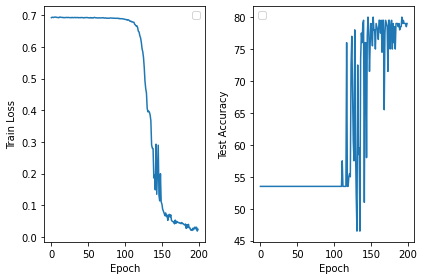

In [150]:
hiddenlayers_sizes = [1024,128,16]
LS = input_layer_size + hiddenlayers_sizes + output_layer_size
DP=0.5
model = MLPListDropout(layers_sizes=LS,droptout_value=DP).to(device)
model.to(device)
print(sum([torch.tensor(x.size()).prod() for x in model.parameters()]))
print(model)
#Parametros que variam
LR =0.05
BS=30
N_EPOCHS = 200
collate_especifico = None

train_loss_list, test_acc_list = evaluate(model,torch_ds_train,torch_ds_test,LR,BS,N_EPOCHS,collate_especifico)
visualization(N_EPOCHS,train_loss_list,test_acc_list)



# Experimento 2 (Embedding Bag)

In [0]:
estrategia = 'embeddingBag'
torch_ds_train = ImdbDataset(X_treino_glove_ids,Y_treino_final,estrategia, X_words=X_treino_glove_words)
torch_ds_test = ImdbDataset(X_valid_glove_ids,Y_valid_final,estrategia,  X_words=X_valid_glove_words)

tensor(120019394)
Sequential(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=2, bias=True)
)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


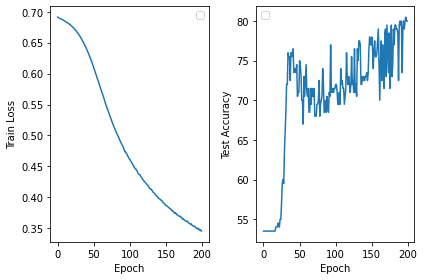

In [126]:
model = MLPListEmbeddings(hidden_dim=64).to(device)
model.to(device)
print(sum([torch.tensor(x.size()).prod() for x in model.parameters()]))
#Parametros que variam
LR =0.009
BS=20
N_EPOCHS = 200
collate_especifico = my_collate

train_loss_list, test_acc_list = evaluate(model,torch_ds_train,torch_ds_test,LR,BS,N_EPOCHS,collate_especifico)
visualization(N_EPOCHS,train_loss_list,test_acc_list)

# Tunando Hyperparâmetros (Estatégia Manual) - Não Utilizado, precisa ser debugado


In [0]:
# Para a tunagem utilizei o core da função do Israel na aula 2

#Parâmetros Fixos
torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
x0, y0 = torch_ds_train[1]
torch_ds_test = ImdbDataset('x_test.csv','y_test.csv')
criterion = torch.nn.CrossEntropyLoss().to(device)
ILS = len(x0)
N_EPOCHS = 100

#Parametros que variam
NUM_LAYERS=[3,4,5,6,7,8,9,10]
DROPOUTS=[0.0,0.1,0.2,0.3,0.4,0.5]
LEARNING_RATES =[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
BATCH_SIZES=[10,25,50,75]

trials = {}
results = {}
id_best_iteration = 0
best_acc = 0
i = 0
for NL in NUM_LAYERS:
  for DP in DROPOUTS:
    for LR in LEARNING_RATES:
      for BS in BATCH_SIZES:
        for EP in range(N_EPOCHS+1):
          model = MLPListDropout(input_layer_size=ILS,num_layers=NL,droptout_value=DP).to(device)
          model.to(device)
          optimizer = torch.optim.SGD(model.parameters(), lr=LR)

          train_loader = DataLoader(torch_ds_train, BS, shuffle=True)
          test_loader = DataLoader(torch_ds_test, BS, shuffle=False)

          train_loss =  train(model, train_loader, criterion, optimizer)
          test_acc =  test(model, test_loader)
          
          best_acc = best_acc if (best_acc>test_acc) else test_acc
          id_best_iteration = id_best_iteration if (best_acc>test_acc) else i

          trials[i] = {
              'lr': LR,
              'num_layers': NL,
              'input_layer_size': ILS,
              'droptout_value': DP,
              'batch_size':BS,
              'epoch':EP,
          }
          results[i] = {
              'train_loss': train_loss,
              'test_acc': test_acc,
          }
          print(trials[i],results[i])
          i += 1


Funções para salvar no pickle

# Tunando Hyperparâmetros (Estatégia com Grid Search) - Não Utilizado, precisa ser debugado


In [0]:
!pip install -q skorch

In [0]:
from skorch import NeuralNetClassifier

torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
x0, y0 = torch_ds_train[1]

# net = NeuralNetClassifier(
#     MLPListDropout,
#     criterion=nn.CrossEntropyLoss(),
#     lr=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1],
#     batch_size=[],
#     max_epochs=25,
#     module__output_features=2,
#     optimizer=optim.SGD,
#     optimizer__momentum=0.9,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=4,
#     iterator_valid__shuffle=True,
#     iterator_valid__num_workers=4,
#     train_split=predefined_split(valid_ds),
#     callbacks=[lrscheduler, checkpoint, freezer],
#     device='cuda' # comment to train on cpu
# )

net = NeuralNetClassifier(
    module=MLPListDropout,
    module__num_layers=[2,3,4,5,6,7,8,9,10],
    module__input_layer_size = len(x0),
    module__droptout_value=[0.1,0.2,0.3,0.4,0.5],
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=[0.7,0.8,0.9],
    max_epochs=[10,25,50,75,100,125,150,175,200],
    lr=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1],
    batch_size=[10,25,50,75],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device=device
)
net.fit(X_treino_tfiff,Y_treino_bool)
y_proba = net.predict_proba(X_treino_tfiff)

In [0]:
from skorch import NeuralNetClassifier
from sklearn.pipeline import Pipeline

torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
x0, y0 = torch_ds_train[1]


# testin DataLoader
torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
train_loader = DataLoader(torch_ds_train, 100, shuffle=False)
x_train, y_train = next(iter(train_loader))

torch_ds_test = ImdbDataset('x_test.csv','y_test.csv')
test_loader = DataLoader(torch_ds_test, 100, shuffle=False)
x_test, y_test = next(iter(test_loader))

# from sklearn.model_selection import GridSearchCV

net = NeuralNetClassifier(
    module=MLPListDropout,
    criterion=torch.nn.CrossEntropyLoss,
    module__num_layers=5,
    module__input_layer_size = len(x0),
    module__droptout_value=0.5,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    max_epochs=200,
    lr=0.0001,
    batch_size=100,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device=device,
)


# pipe = Pipeline([
#     ('model', MLPListDropout()),
#     ('criterion', torch.nn.CrossEntropyLoss),
# ])

params = {
    'module__num_layers': [2,3,4,5,6,7,8,9,10],
    'module__input_layer_size':  [len(x0)],
    'module__droptout_value': [0,0.1,0.2,0.3,0.4,0.5],
    'optimizer__momentum':[0.7,0.8,0.9],
    'max_epochs':[10,25,50,75,100,125,150,175,200],
    'lr':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1],
    'batch_size':[10,25,50,75,100],
}

print(net)

gs = GridSearchCV(net, params, refit=False, cv=5, scoring='accuracy')


gs.fit(X_treino_tfiff, Y_treino_bool)
print(gs.best_score_, gs.best_params_)